In [1]:
import numpy as np
import tensorflow as tf
#import tensorflow_quantum as tfq
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, Layer, Reshape, Dropout, LeakyReLU, BatchNormalization, Flatten
from keras.initializers import RandomNormal
from sklearn import datasets

#import cirq
import sympy

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
#from cirq.contrib.svg import SVGCircuit

from IPython import display
import glob
from PIL import Image
from tqdm import tqdm
import datetime

# mlflow tools
import mlflow
from mlflow.tracking import MlflowClient



2022-11-16 13:44:31.233813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 13:44:31.233862: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext tensorboard

## Parameters

In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/GAN/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(log_dir)

#gen_init_layer_size = (7, 7, 256) # generator input size
gen_init_layer_size = (2, 2, 16)
disc_input_shape = (8, 8, 1) # discriminator input shape
z_dim = 10  # random noise dimension

buffer_size = 60000
batch_size = 256

2022-11-16 13:44:33.864714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 13:44:33.864757: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 13:44:33.864773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2022-11-16 13:44:33.865028: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset

In [4]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

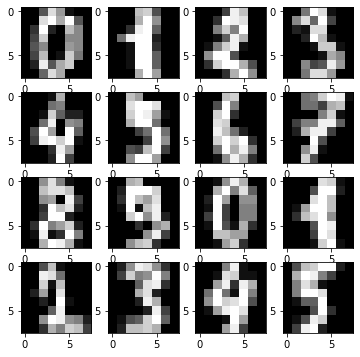

In [5]:
plt.figure(figsize=(6, 6))

for i, image in enumerate(digits.images[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [6]:
x = np.array([t for t, l in zip(x_train, y_train) if l in (0, 1)])

x.shape, x.max()

((360, 8, 8), 16.0)

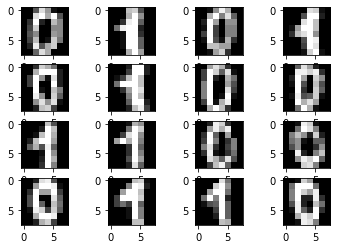

In [7]:
for i, image in enumerate(x[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [8]:
x = x.reshape(x.shape[0], 8, 8, 1).astype('float32')
x = (x - 8) / 8
x

array([[[[-1.   ],
         [-1.   ],
         [-0.375],
         ...,
         [-0.875],
         [-1.   ],
         [-1.   ]],

        [[-1.   ],
         [-1.   ],
         [ 0.625],
         ...,
         [ 0.875],
         [-0.375],
         [-1.   ]],

        [[-1.   ],
         [-0.625],
         [ 0.875],
         ...,
         [ 0.375],
         [ 0.   ],
         [-1.   ]],

        ...,

        [[-1.   ],
         [-0.5  ],
         [ 0.375],
         ...,
         [ 0.5  ],
         [-0.125],
         [-1.   ]],

        [[-1.   ],
         [-0.75 ],
         [ 0.75 ],
         ...,
         [ 0.5  ],
         [-1.   ],
         [-1.   ]],

        [[-1.   ],
         [-1.   ],
         [-0.25 ],
         ...,
         [-1.   ],
         [-1.   ],
         [-1.   ]]],


       [[[-1.   ],
         [-1.   ],
         [-1.   ],
         ...,
         [-0.375],
         [-1.   ],
         [-1.   ]],

        [[-1.   ],
         [-1.   ],
         [-1.   ],
         ...,
   

In [9]:
x_train = x_train.reshape(x_train.shape[0], 8, 8, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5
x_train.shape

(1797, 8, 8, 1)

In [10]:
train_dataset_digits = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:10]).shuffle(buffer_size).batch(batch_size

In [11]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

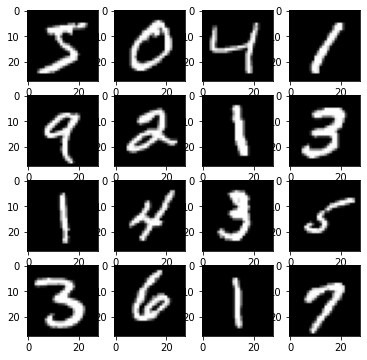

In [12]:
plt.figure(figsize=(6, 6))

for i, image in enumerate(train_images[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break   

In [13]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # normalize the images to [-1, 1]
#x_train = train_images[30000:]
train_images.shape

(60000, 28, 28, 1)

In [14]:
# batch and shuffle the data
train_dataset_mnist = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:10]).shuffle(buffer_size).batch(batch_size)

for element in train_dataset_mnist:
   print(element)

tf.Tensor(
[[[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
 

### Classical GAN

In [15]:
'''
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x)

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')
'''

"\nclass generator():\n\n    def __init__(self, gen_init_layer_size, z_dim):\n\n        super(generator, self).__init__()\n        self.gen_init_layer_size = gen_init_layer_size\n        self.z_dim = z_dim\n        self.gen_weight = RandomNormal(mean=0., stddev=1.0)\n        self.input = Input(shape=self.z_dim)\n        \n\n    def build_gen(self):\n\n        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, \n                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        \n        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)\n        x = BatchNorm

In [16]:
'''
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  
'''

"\nclass discriminator():\n    def __init__(self, disc_input_shape):\n        \n        super(discriminator, self).__init__() \n        self.disc_input_shape = disc_input_shape\n        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) \n        self.input = Input(shape=self.disc_input_shape)    \n              \n\n    def build_disc(self):\n        \n        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Flatten()(x)\n        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)\n\n        output = x\n\n        return Model(self.input, output, name = 'Discriminator_Network')  \n"

In [17]:
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x) 

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')

Model: "Generator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 128)        51200     
 nspose)                                         

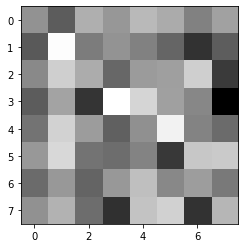

In [18]:
# Defining generator network
z_noise = tf.random.normal([6, z_dim])
gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
gen_net = gen.build_gen()
generated_image = gen_net(z_noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#generated_image
gen_net.summary()

In [19]:
generated_image

<tf.Tensor: shape=(6, 8, 8, 1), dtype=float32, numpy=
array([[[[ 4.30970918e-03],
         [-2.83354335e-02],
         [ 2.21233796e-02],
         [ 7.45340204e-03],
         [ 2.80895699e-02],
         [ 1.98908765e-02],
         [-5.63033158e-03],
         [ 1.37455370e-02]],

        [[-3.04226838e-02],
         [ 6.98680356e-02],
         [-8.77190474e-03],
         [ 5.04210778e-03],
         [-5.61211864e-03],
         [-2.29379460e-02],
         [-5.42653315e-02],
         [-2.75114663e-02]],

        [[-8.48047144e-04],
         [ 4.18466367e-02],
         [ 2.06972193e-02],
         [-2.14880202e-02],
         [ 1.00349048e-02],
         [ 1.22922268e-02],
         [ 4.15119193e-02],
         [-4.93186638e-02]],

        [[-2.81861480e-02],
         [ 1.48228090e-02],
         [-5.22602797e-02],
         [ 7.13051409e-02],
         [ 4.55177166e-02],
         [ 1.31593132e-02],
         [-2.25052214e-03],
         [-8.47451463e-02]],

        [[-1.44517729e-02],
         [ 4.3

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def gen_loss(fake_out):
        return loss(tf.ones_like(fake_out), fake_out)

gen_opt = tf.keras.optimizers.Adam(0.3)

In [21]:
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
    #image = tf.expand_dims(image, axis = 0)
    generated_images = gen_net(z_noise, training=True)
    #print('gen img', generated_images.shape)

    #real_out = disc_net(image, training = True)
    
    fake_out = disc_net(generated_images, training = True)
    #print('fake_out: ', fake_out)

    gl = gen_loss(fake_out)
    #print('gen loss: ', gl)
    #print('pgg w: ', gen_net.trainable_variables)
    #disc_loss = disc_loss(real_out, fake_out)

gradients_of_generator = gen_tape.gradient(gl, gen_net.trainable_variables)
print('Gradient gen: ', gradients_of_generator)

gen_opt.apply_gradients(zip(gradients_of_generator, gen_net.trainable_variables))

NameError: name 'disc_net' is not defined

In [ ]:
np.array(gen_net.trainable_variables).shape

/tmp/ipykernel_212/1463194730.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(gen_net.trainable_variables).shape


(10,)

In [ ]:
gen_net.trainable_variables

[<tf.Variable 'dense_4/kernel:0' shape=(10, 64) dtype=float32, numpy=
 array([[ 6.51442647e-01, -4.47223693e-01, -6.66008830e-01,
         -4.99603927e-01,  8.05074096e-01,  1.17598474e+00,
          1.47184157e+00,  1.09403300e+00, -5.87883770e-01,
         -6.68652296e-01, -3.14354450e-01, -7.36627340e-01,
         -9.99231279e-01, -9.41210687e-01, -1.20052767e+00,
         -1.29720020e+00, -1.27663517e+00, -7.21268654e-01,
         -1.76807141e+00,  1.09198260e+00,  5.66967070e-01,
         -4.47157919e-02,  1.48954201e+00,  1.63907480e+00,
          1.59415424e-01, -2.23509932e+00, -2.80264783e+00,
         -6.83455408e-01, -7.38667548e-01,  4.80008185e-01,
         -3.29958439e-01, -2.78373361e-01, -4.48439240e-01,
          7.77684689e-01,  1.52381945e+00,  1.06676722e+00,
          2.86320567e-01,  9.04986978e-01,  1.32187140e+00,
          3.64044309e-01,  6.97731674e-01, -1.01292098e+00,
          3.84047568e-01, -1.06948555e+00, -1.04428887e+00,
          3.87441367e-01, -5.0

In [22]:
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1)(x)#, kernel_initializer = self.disc_weight)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  

In [23]:
# Defining discriminator network
disc = discriminator(disc_input_shape = disc_input_shape)
disc_net = disc.build_disc()

a = x_train[0]
a = tf.expand_dims(a, axis = 0)
print(disc_net(a))

disc_net.summary()

tf.Tensor([[-0.04506669]], shape=(1, 1), dtype=float32)
Model: "Discriminator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 128)         0         
                                                       

In [24]:
disc_net.trainable_weights

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
 array([[[[-0.04974108,  0.04226772,  0.05274835, ...,  0.01481328,
           -0.00706577,  0.04972195]],
 
         [[-0.03843208,  0.01814874,  0.04486566, ..., -0.05873745,
            0.04261808, -0.04575759]],
 
         [[-0.04709383, -0.03326612, -0.01657024, ...,  0.01114243,
            0.03548335,  0.01965768]],
 
         [[ 0.04825253,  0.03569541, -0.04604319, ...,  0.05289564,
            0.04913888, -0.04914801]],
 
         [[-0.04579748, -0.04118249,  0.02799999, ..., -0.02119508,
            0.00263302,  0.03593846]]],
 
 
        [[[ 0.03135527, -0.02751247,  0.04570876, ..., -0.04567893,
            0.04682739, -0.0118224 ]],
 
         [[ 0.0589426 ,  0.05690125,  0.00480638, ..., -0.03883088,
            0.01288931, -0.00938967]],
 
         [[ 0.04788999,  0.03067961,  0.02604604, ...,  0.04523689,
           -0.03694924,  0.03479619]],
 
         [[ 0.05368707, -0.05527047,  0.00375521, .

In [28]:
class Trainer():

    def __init__(self, x_train, gen_net, disc_net, gen_init_layer_size, z_dim, disc_input_shape, batch_size, writer, log_dir, logging = True):
        super(Trainer, self).__init__()
        self.x_train = x_train
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.disc_input_shape = disc_input_shape
        self.gen_opt = tf.keras.optimizers.Adam(1e-4)
        self.disc_opt = tf.keras.optimizers.Adam(1e-4) 
        self.batch_size = batch_size      
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
        self.gen_net = gen_net 
        self.disc_net = disc_net  
        self.writer = writer  
        self.logging= logging  
        self.log_dir = log_dir

        self.g_loss = []
        self.d_loss = []
    
    def gen_loss(self, fake_out):
        return self.loss(tf.ones_like(fake_out), fake_out)


    def disc_loss(self, img, fake_out):

        real_loss = self.loss(tf.ones_like(img), img)
        fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)

        total_loss = real_loss + fake_loss
        return total_loss   


    def generate_and_save_images(self, model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)
        #print(predictions.shape)

        plt.figure(figsize=(6, 6))

        for i, image in enumerate(predictions, 1):
            try:
                plt.subplot(4, 4, i)
                plt.imshow(image, cmap='gray')
            except ValueError:
                break       
        
        plt.savefig(self.log_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


    def train_step(self, image):

        noise = tf.random.normal([self.batch_size, self.z_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #image = tf.expand_dims(image, axis = 0)
            generated_images = self.gen_net(noise, training=True)
            #print('gen img', generated_images.shape)

            real_out = self.disc_net(image, training = True)
            fake_out = self.disc_net(generated_images, training = True)
            #print('fake_out: ', fake_out)

            gen_loss = self.gen_loss(fake_out)
            #print('gen loss: ', gen_loss)
            disc_loss = self.disc_loss(real_out, fake_out)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen_net.trainable_variables)
        #print('Gradient gen: ', gradients_of_generator)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_of_generator, self.gen_net.trainable_variables))
        self.disc_opt.apply_gradients(zip(gradients_of_discriminator, self.disc_net.trainable_variables))
            
        return gen_loss, disc_loss


    def learn(self, epochs):

        #print(len(self.x_train))

        #with tqdm(range(epochs), desc="GAN", unit="epochs") as tepochs:

        for epoch in range(epochs):

            print(f'EPOCH {epoch+1}')

            i = 0

            for j, batch_img in enumerate(self.x_train):

                gl, dl = self.train_step(batch_img)                

                i += 1
                print(f'Step {i}')

                self.g_loss.append(gl)
                self.d_loss.append(dl)

                with self.writer.as_default():
                    # save for tensorboard
                    tf.summary.scalar('Generator loss', data=gl, step=epoch* len(self.x_train) + j)
                    tf.summary.scalar('Discriminator loss', data=dl, step=epoch* len(self.x_train) + j)

                # log the reward with mlflow
                if self.logging:
                    mlflow.log_metric('Generator loss', gl, step=epoch* len(self.x_train) + j)
                    mlflow.log_metric('Discriminator loss', dl, step=epoch* len(self.x_train) + j)


            # produce images 
            display.clear_output(wait=True)
            self.generate_and_save_images(self.gen_net, epoch + 1, tf.random.normal([self.batch_size, self.z_dim]))  

            # save model with tensorflow
            if self.logging:            
                with self.writer.as_default():
                    tf.saved_model.save(self.gen_net, self.log_dir + f'generator_network')
                    tf.saved_model.save(self.disc_net, self.log_dir + f'discriminator_network')       
            

            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

            #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

## Training

In [29]:
z_dim = 2
batch_size = 4
buffer_size = 360
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)

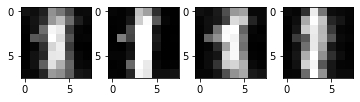

INFO:tensorflow:Assets written to: logs/GAN/20221116-134433/generator_network/assets
INFO:tensorflow:Assets written to: logs/GAN/20221116-134433/discriminator_network/assets
EPOCH 23
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77


KeyboardInterrupt: 

In [30]:
# mlflow experiment settings
client = MlflowClient()
experiments = client.list_experiments()
experiment_name = 'Classical GAN'
#experiment_id = client.create_experiment(experiment_name)
#client.set_experiment_tag(experiment_id, 'GAN', 'GM')
print('Setting up experiment')
experiment = client.get_experiment_by_name(experiment_name)
experiment = mlflow.set_experiment(experiment_name=experiment_name)
experiment_id = experiment.experiment_id
run_name = 'Run'
i=0

with mlflow.start_run(run_name=run_name):
    # setting up generator and actor networks
    gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
    gen_net = gen.build_gen()
    disc = discriminator(disc_input_shape = disc_input_shape)
    disc_net = disc.build_disc()

    # starting mlflow run
    with mlflow.start_run(run_name=f'{run_name}_{i}', nested=True) as run:
        
        # training
        trainer = Trainer(x_train = train_dataset, gen_net = gen_net, disc_net = disc_net, gen_init_layer_size = gen_init_layer_size, z_dim = z_dim, 
                          disc_input_shape = disc_input_shape, batch_size = batch_size, writer = summary_writer, log_dir = log_dir)

        %tensorboard --logdir logs/

        trainer.learn(50)
        
        # log and save the model in mlflow
        print('Saving models in mlflow...')
        models = ['generator_network', 'discriminator_network']
        artifact_path = f'mlruns/{experiment_id}/{run.info.run_id}/'
        for m in models:
            mlflow.tensorflow.save_model(tf_saved_model_dir = log_dir + m,
                                         tf_meta_graph_tags = None,
                                         tf_signature_def_key = "serving_default",
                                         path = artifact_path + "artifacts/" + m) 
    i+=1

### GIF

In [ ]:
# filepaths (fp)
fp_in = "/home/ludoboz/Projects/GAN & QGAN/logs/GAN/20221011-163716/image_at_epoch_*.png"
fp_out = "/home/ludoboz/Projects/GAN & QGAN/GAN.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=150, loop=0)

In [ ]:
plt.figure(figsize=(2, 2))

# all 0s
vector = np.array([[0 for _ in range(8)]])
# generate image
X = gen_net.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray')

plt.show()

In [ ]:
vector = np.array([[0 for _ in range(8)]])
vector

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[11, :, :, 0], cmap='gray')

In [ ]:
x_train.shape

In [ ]:
#self.discriminator.compile(optimizer=self.disc_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#model_input = Input(shape=(self.z_dim,), name='model_input')
#model_output = self.discriminator(self.generator(model_input))
#self.model = Model(model_input, model_output)

#self.model.compile(optimizer=self.disc_opt , loss='binary_crossentropy', metrics=['accuracy'])   

#def adversarial_model(self):    
    #pass

#def train_generator(self):

#    valid = np.ones((self.batch_size,1))
#    noise = tf.random.normal(shape = (self.batch_size, self.z_dim), mean = 0, stddev = 1)

    #self.generator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

#    return self.model.train_on_batch(noise, valid)


#def train_discriminator(self):

#    valid = np.ones((self.batch_size,1))
#    fake = np.zeros((self.batch_size,1))
    
    #self.discriminator.compile(optimizer=self.disc_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

#    for true_imgs in self.x_train:

#        a = tf.expand_dims(true_imgs, axis = 0)

    #true_imgs = next(self.x_train)[0]
    #if true_imgs.shape[0] != self.batch_size:
    #    true_imgs = next(self.x_train)[0]  
#        noise = tf.random.normal(shape = (self.batch_size, self.z_dim), mean = 0, stddev = 1)
#        gen_imgs = self.gen_net.predict(noise)     

#        disc_loss_real, disc_acc_real =  self.discriminator.train_on_batch(a, valid)
#        disc_loss_fake, disc_acc_fake =  self.discriminator.train_on_batch(gen_imgs, fake)
#        disc_loss =  0.5 * (disc_loss_real + disc_loss_fake)
#        disc_acc = 0.5 * (disc_acc_real + disc_acc_fake)

#    return [disc_loss, disc_loss_real, disc_loss_fake, disc_acc, disc_acc_real, disc_acc_fake]

#def train(self):

#    for epoch in range(self.epochs):
        
#        d = self.train_discriminator()
#        g = self.train_generator()

#        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

#        self.d_loss.append(d[0])
#        self.g_loss.append(g)